In [765]:
# Imports
import pandas as pd
from typing import Dict
import seaborn as sns

In [766]:
# File paths
NEW_BUILD_CSV: str = "Data/Neubauwohnungen_Zürich.csv"
TAXABLE_INCOME_CSV: str = "Data/Vermögen_Stadt_zürich.csv"
EQUIVALIZED_INCOME_CSV: str = "Data/Haushaltsäquivalenz-Einkommen.csv"

In [767]:
NEW_BUILD_COLMAP: Dict[str, str] = {
    # grouping
    "KreisLang": "district_name",
    "QuarLang": "quarter_name",
    "FuenfjahresPeriode_noDM": "five_year_period",
    # metrics
    "AnzRentner": "num_retirees",
    "AnzKinder": "num_children",
    "Wohnflaeche": "living_area",
    "AnzZimmerLevel2Cd_noDM": "num_rooms",
    "AnzWhgStat": "num_appartments",
    "AnzBestWir": "population_total",
    "MietwohnungSort": "num_rental_apartment",  
}

TAXABLE_INCOME_COLMAP: Dict[str, str] = {
    "KreisLang": "district_name",
    "StichtagDatJahr": "year",
    "SteuerEinkommen_p50": "taxable_income_p50",  # median taxable income (per year)
}

EQUIVALIZED_INCOME_COLMAP: Dict[str, str] = {
    "KreisLang": "district_name",
    "StichtagDatJahr": "year",
    "aequEK_p50": "equivalized_income_p50",  # median equivalized income (per year)
}

In [768]:
def load_and_rename(csv_path: str, colmap: Dict[str, str]) -> pd.DataFrame:
    """Rename the CSV files"""
    df = pd.read_csv(csv_path)
    return df.rename(columns=colmap)

In [769]:
def aggregate_new_build_by_district(csv_path: str = NEW_BUILD_CSV) -> pd.DataFrame:
    """
    Aggregate new-build apartments by district and five-year period.
    Logic matches the original:
      - sums of retirees, children, living area, rooms, appartements, population, rental_appartments
    """
    df = load_and_rename(csv_path, NEW_BUILD_COLMAP)

    aggregated = (
        df.groupby(["district_name", "five_year_period"])
          .agg(
              num_retirees=("num_retirees", "sum"),
              num_children=("num_children", "sum"),
              living_area=("living_area", "sum"),
              num_rooms=("num_rooms", "sum"),
              num_dwellings=("num_appartments", "sum"),
              population_total=("population_total", "sum"),
              rental_dwellings=("num_rental_apartment", lambda x: (x == 1).sum()),
          )
          .reset_index()
    )

    return aggregated

In [770]:
def aggregate_new_build_by_quarter(csv_path: str = NEW_BUILD_CSV) -> pd.DataFrame:
    """
    Aggregate new-build apartments by quarter and five-year period.
    Same metrics and logic as the district-level aggregation.
    """
    df = load_and_rename(csv_path, NEW_BUILD_COLMAP)

    aggregated = (
        df.groupby(["quarter_name", "five_year_period"])
          .agg(
              num_retirees=("num_retirees", "sum"),
              num_children=("num_children", "sum"),
              living_area=("living_area", "sum"),
              num_rooms=("num_rooms", "sum"),
              num_dwellings=("num_appartments", "sum"),
              population_total=("population_total", "sum"),
              rental_dwellings=("num_rental_apartment", lambda s: (s == 1).sum()),
          )
          .reset_index()
    )

    return aggregated

In [771]:
def aggregate_taxable_income_by_district(
    csv_path: str = TAXABLE_INCOME_CSV,
    year_min_inclusive: int = 2015,
    year_max_exclusive: int = 2019,
) -> pd.DataFrame:
    """
    Filter to years >= 2015, then group by district and compute the mean of the
    annual median taxable incomes (p50). Matches the original logic exactly.
    """
    df = load_and_rename(csv_path, TAXABLE_INCOME_COLMAP)
    df = df[(df["year"] >= year_min_inclusive) & (df["year"] < year_max_exclusive)]

    aggregated = (
        df.groupby("district_name")
          .agg(median_taxable_income=("taxable_income_p50", "mean"))
          .reset_index()
    )
    return aggregated

In [772]:
def aggregate_equivalized_income_by_district(
    csv_path: str = EQUIVALIZED_INCOME_CSV,
    year_min_inclusive: int = 2015,
    year_max_exclusive: int = 2019,
) -> pd.DataFrame:
    """
    Filter to 2015 <= year < 2019, then group by district and compute the mean
    of the annual median equivalized incomes (p50). Matches original logic.
    """
    df = load_and_rename(csv_path, EQUIVALIZED_INCOME_COLMAP)
    df = df[(df["year"] >= year_min_inclusive) & (df["year"] < year_max_exclusive)]

    aggregated = (
        df.groupby("district_name")
          .agg(median_equivalized_income=("equivalized_income_p50", "mean"))
          .reset_index()
    )
    return aggregated

In [773]:
def build_join_df(
    taxable_income_by_district: pd.DataFrame,
    new_build_by_district: pd.DataFrame,
    equivalized_income_by_district: pd.DataFrame,
) -> pd.DataFrame:
    """
    Reproduce the two-step LEFT/RIGHT merge from the original code:
      1) LEFT join taxable_income_by_district with new_build_by_district on district
      2) RIGHT join result with equivalized_income_by_district on district
    The final 'right' join ensures all districts from the taxable/new_build join
    are kept (as per original).
    """
    join_left = pd.merge(
        taxable_income_by_district,
        new_build_by_district,
        on="district_name",
        how="left",
    )

    joined = pd.merge(
        equivalized_income_by_district,
        join_left,
        on="district_name",
        how="right",
    )
    return joined


In [774]:
# New-build aggregations (district & quarter)
new_build_by_quarter = aggregate_new_build_by_quarter()
new_build_by_district = aggregate_new_build_by_district()

# Income aggregations
taxable_income_by_district = aggregate_taxable_income_by_district()
equivalized_income_by_district = aggregate_equivalized_income_by_district()

# Final join
joined_df = build_join_df(
    taxable_income_by_district=taxable_income_by_district,
    new_build_by_district=new_build_by_district,
    equivalized_income_by_district=equivalized_income_by_district,
)

# View results
(new_build_by_quarter)
(taxable_income_by_district)
(equivalized_income_by_district)
(joined_df)


,district_name,median_equivalized_income,median_taxable_income,five_year_period,num_retirees,num_children,living_area,num_rooms,num_dwellings,population_total,rental_dwellings
0,Kreis 1,65.257037,77.108333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Kreis 10,56.927500,64.533333,2015–2019,138.0,521.0,81799.0,527.0,878.0,2051.0,120.0
2,Kreis 10,56.927500,64.533333,2020–2024,53.0,207.0,39621.0,425.0,446.0,963.0,88.0
3,Kreis 11,50.025250,52.108333,2015–2019,282.0,645.0,152628.0,1127.0,1694.0,3545.0,250.0
4,Kreis 11,50.025250,52.108333,2020–2024,309.0,989.0,193924.0,974.0,2389.0,5056.0,247.0
5,Kreis 12,39.501111,41.454167,2015–2019,402.0,1003.0,157775.0,516.0,1779.0,4327.0,154.0
6,Kreis 12,39.501111,41.454167,2020–2024,216.0,197.0,45411.0,402.0,582.0,1145.0,107.0
7,Kreis 2,58.973500,64.537500,2015–2019,218.0,921.0,133098.0,714.0,1412.0,3506.0,163.0
8,Kreis 2,58.973500,64.537500,2020–2024,178.0,824.0,137466.0,645.0,1623.0,3631.0,165.0
9,Kreis 3,51.827000,54.562500,2015–2019,192.0,425.0,62254.0,499.0,740.0,1722.0,129.0


In [775]:
import pandas as pd
import numpy as np


data = pd.read_csv("Data/Wohnungen_Zürich.csv")
df_3 = data[["KreisLang", "KreisSort", "AnzZimmerLevel1Cd_noDM", "BauperiodeLevel1Lang","BauperiodeLevel1Sort","AnzWhgStat","Wohnflaeche"]].copy()

df_3 = df_3.groupby(["KreisLang", "KreisSort", "BauperiodeLevel1Lang", "BauperiodeLevel1Sort"]).aggregate({
    "AnzZimmerLevel1Cd_noDM": "sum",
    "AnzWhgStat": "sum",
    "Wohnflaeche": "sum"   
}).reset_index()

df_3 = df_3.rename(columns={
    "KreisLang": "district_name",
    "KreisSort": "district_sort",
    "BauperiodeLevel1Lang": "building_period",
    "BauperiodeLevel1Sort": "building_period_sort",
    "AnzZimmerLevel1Cd_noDM": "num_rooms",
    "AnzWhgStat": "num_appartments",
    "Wohnflaeche": "living_area"
})

df_3["percentage_appartments"] = (
    df_3["num_appartments"] /
    df_3.groupby("district_name")["num_appartments"].transform("sum")
)

df_3["percentage_area"] = (
    df_3["living_area"] /
    df_3.groupby("district_name")["living_area"].transform("sum")
)

df_3["area_per_appartment"] = (
    df_3["living_area"] /
    df_3["num_appartments"]
)

df_3["rooms_per_appartment"] = (
    df_3["num_rooms"] /
    df_3["num_appartments"]
)

df_3 = df_3[df_3["building_period_sort"] != 1]

df_3["rooms_per_appartment_z"] = (
    df_3["rooms_per_appartment"] - df_3["rooms_per_appartment"].mean()
) / df_3["rooms_per_appartment"].std()

df_3["area_per_appartment_z"] = (
    df_3["area_per_appartment"] - df_3["area_per_appartment"].mean()
) / df_3["area_per_appartment"].std()

c:\Users\livio\Documents\FHNW\gdv\venv_gdv\Lib\site-packages\pywaffle\waffle.py:283: PendingDeprecationWarning: The set_tight_layout function will be deprecated in a future version. Use set_layout_engine instead.
  self.set_tight_layout(self.fig_args["tight"])


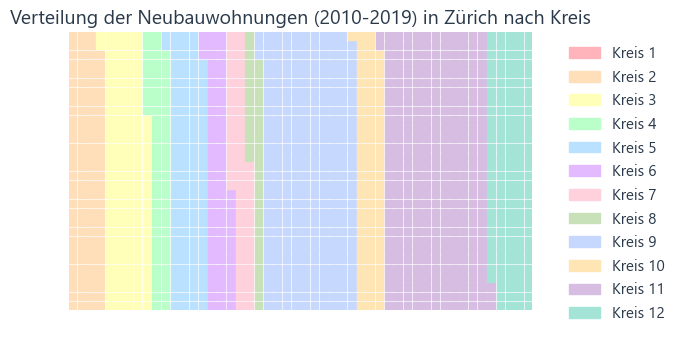

In [776]:
import matplotlib.pyplot as plt
from pywaffle import Waffle

colors = [
    "#ffb3ba",  # Pastellrot
    "#ffdfba",  # Pastellorange
    "#ffffba",  # Pastellgelb
    "#baffc9",  # Pastellgrün
    "#bae1ff",  # Pastellblau
    "#e3baff",  # Pastelllila
    "#ffd1dc",  # Zartrosa
    "#c8e1b8",  # Salbeigrün
    "#c7d8ff",  # Perlblau
    "#ffe5b4",  # Peach
    "#d7bde2",  # Flieder
    "#a3e4d7"   # Türkispastell
]



data = (
    df_3[df_3["building_period"] == "2010 - 2019"]
    .groupby(["district_name","district_sort"])["num_appartments"]
    .sum()
    .reset_index()
    .sort_values("district_sort")
    .set_index("district_name")["num_appartments"]
)

values = data.to_dict()

plt.figure(
    FigureClass=Waffle,
    rows=30,
    columns=50,
    values=values,
    colors=colors[:len(values)],  # falls weniger als 12 Kategorien
    legend={'loc': 'upper left', 'bbox_to_anchor': (1.05, 1)}
)
plt.title("Verteilung der Neubauwohnungen (2010-2019) in Zürich nach Kreis")

plt.show()



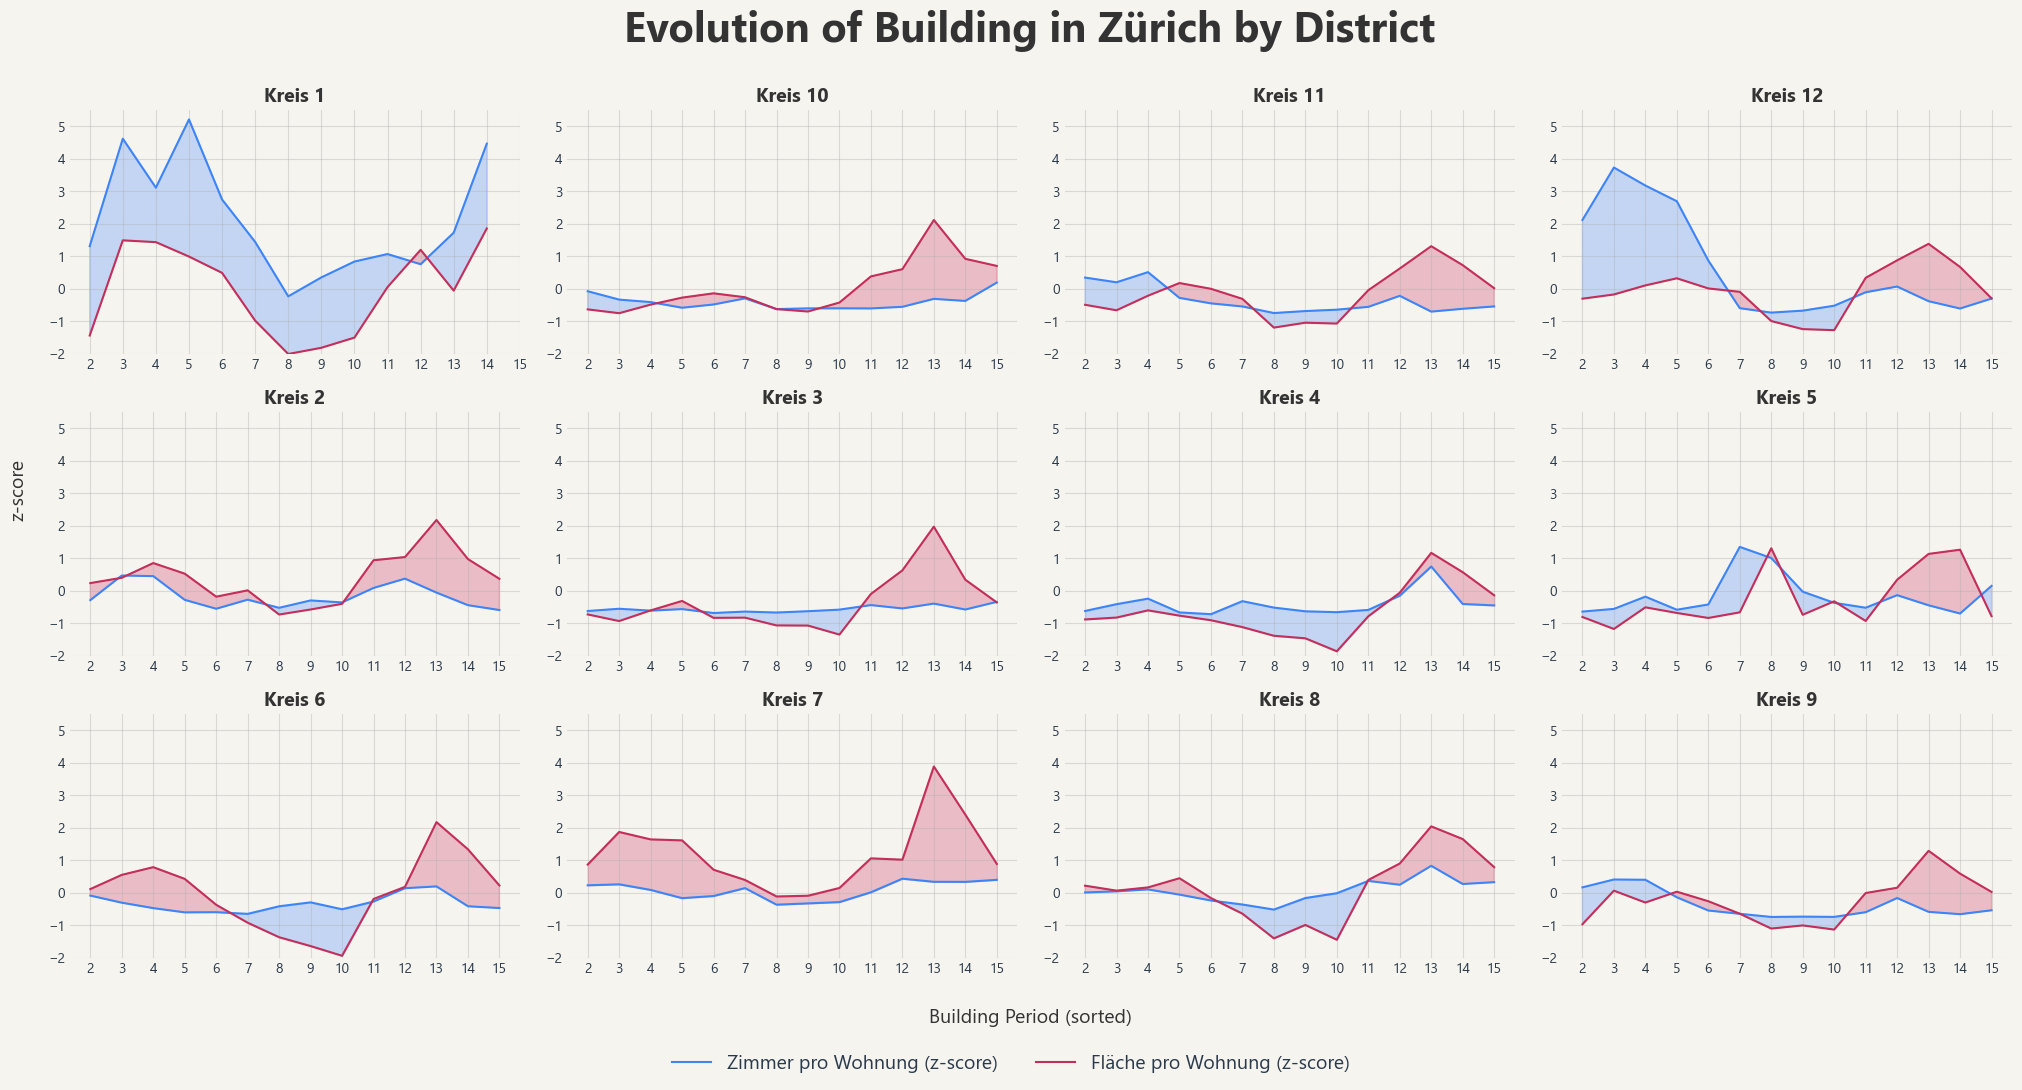

<Figure size 640x480 with 0 Axes>

In [777]:
import matplotlib.pyplot as plt
import numpy as np

BLUE = "#3D85F7"
BLUE_LIGHT = "#5490FF"
PINK = "#C32E5A"
PINK_LIGHT = "#D34068"
GREY40 = "#666666"
GREY25 = "#404040"
GREY20 = "#333333"
BACKGROUND = "#F5F4EF"

districts = sorted(df_3["district_name"].unique())[:12]

# Alle x-Werte (1,2,3,...)
x_vals = np.sort(df_3["building_period_sort"].unique())

# Mapping Sort → Jahresperiode
period_map_df = (
    df_3[["building_period_sort", "building_period"]]
    .drop_duplicates()
    .sort_values("building_period_sort")
)

fig, axes = plt.subplots(3, 4, figsize=(20, 12))
axes = axes.flatten()

# Legendenlinien
line1 = plt.Line2D([], [], color=BLUE, label="Zimmer pro Wohnung (z-score)")
line2 = plt.Line2D([], [], color=PINK, label="Fläche pro Wohnung (z-score)")

for ax, district in zip(axes, districts):

    df = df_3[df_3["district_name"] == district]

    YEAR = df["building_period_sort"].values
    CAT = df["rooms_per_appartment_z"].values
    NOT_CAT = df["area_per_appartment_z"].values

    ax.plot(YEAR, CAT, color=BLUE)
    ax.plot(YEAR, NOT_CAT, color=PINK)

    ax.fill_between(YEAR, CAT, NOT_CAT, where=(CAT > NOT_CAT),
                    interpolate=True, color=BLUE_LIGHT, alpha=0.3)
    ax.fill_between(YEAR, CAT, NOT_CAT, where=(CAT <= NOT_CAT),
                    interpolate=True, color=PINK_LIGHT, alpha=0.3)

    # Einheitliche X-Achse
    ax.set_xticks(x_vals)

    # Einheitliche Y-Skala
    ax.set_ylim(-2, 5.5)

    # Styling
    ax.set_facecolor(BACKGROUND)
    for spine in ax.spines.values():
        spine.set_color("none")

    ax.grid(which="minor", lw=0.4, alpha=0.4)
    ax.grid(which="major", lw=0.8, alpha=0.4)
    ax.tick_params(axis="both", length=0)

    ax.set_title(district, weight="bold", color=GREY20)

fig.set_facecolor(BACKGROUND)

# Titel
fig.text(
    0.5, 0.9,
    "Evolution of Building in Zürich by District",
    ha="center", va="top",
    fontsize=30, fontweight="bold", color=GREY20
)

# Gemeinsame Y-Achse
fig.text(
    -0.01, 0.5, "z-score",
    va="center", rotation="vertical",
    fontsize=14, color=GREY20
)

# Gemeinsame X-Achse
fig.text(
    0.5, 0.06, "Building Period (sorted)",
    ha="center", va="center",
    fontsize=14, color=GREY20
)

# Legende
fig.legend(
    handles=[line1, line2],
    loc="lower center",
    ncol=2,
    frameon=False,
    fontsize=14
)

plt.tight_layout(rect=[0, 0.08, 1, 0.85])
plt.show()


fig.set_facecolor(BACKGROUND)

# ✔ TEXT statt Title — exakt gleiche Position wie suptitle, zentriert
fig.text(
    0.5, 0.9,
    "Evolution of Building in Zürich by District",
    ha="center", va="top",
    fontsize=30, fontweight="bold", color=GREY20
)

# Legende
fig.legend(
    handles=[line1, line2],
    loc="lower center",
    ncol=2,
    frameon=False,
    fontsize=14
)

# Erklärung unter der Legende

plt.tight_layout(rect=[0, 0.08, 1, 0.85])
plt.show()


C:\Users\livio\AppData\Local\Temp\ipykernel_10156\963832079.py:300: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


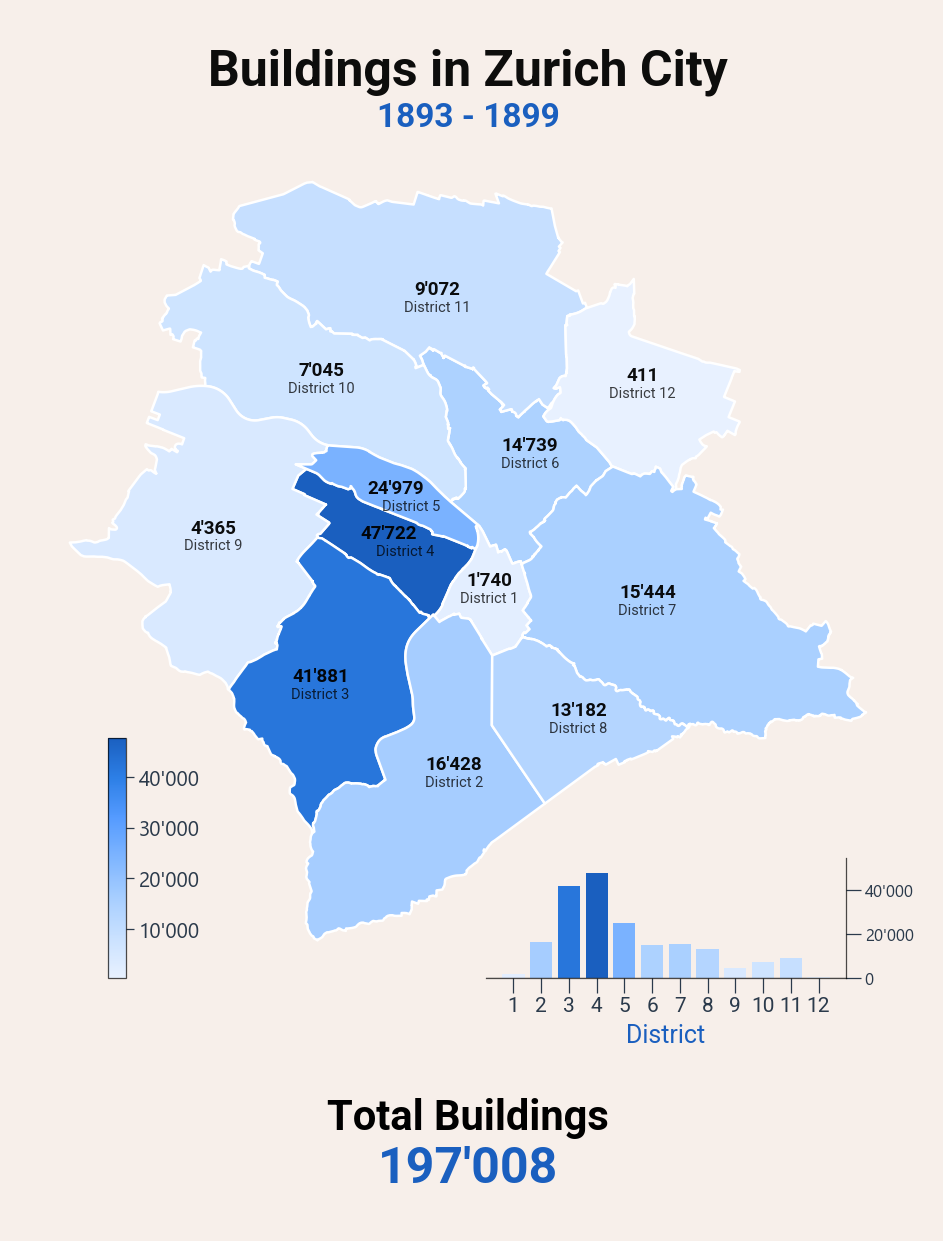

In [778]:
# ==============================
# Imports
# ==============================
import numpy as np
import pandas as pd
import geopandas as gpd

import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from highlight_text import fig_text

import cartopy.crs as ccrs

from pypalettes import create_cmap
from matplotlib.cm import ScalarMappable
from matplotlib import colors
import matplotlib.ticker as mticker

from pyfonts import load_google_font


# ==============================
# Consistent styling constants
# ==============================

# Figure background
BACKGROUND = "#f7efea"
text_color = "black"

# Projection
proj = ccrs.Mercator()

# Load fonts
regular = load_google_font("Roboto")
bold = load_google_font("Roboto", weight="bold")

# Unified Alpha Levels
ALPHA_PRIMARY = 0.95
ALPHA_SECONDARY = 0.75

# Figure text spacing
TITLE_Y = 0.95
TITLE_GAP = 0.045
SUBTITLE_Y = TITLE_Y - TITLE_GAP

# Label offsets for map polygons
LABEL_DY_VALUE = 0.0015
LABEL_DY_NAME = -0.0012

# KPI Block
KPI_X = 0.5
KPI_Y = 0.035
KPI_GAP = 0.04
KPI_LABEL_Y = KPI_Y + KPI_GAP

# Colormap
cmap = create_cmap(
    colors=[
        "#E8F1FF",
        "#C9E1FF",
        "#A7CEFF",
        "#7EB5FF",
        "#559BFF",
        "#2D7FE6",
        "#1A5FBF",
    ],
    cmap_type="continuous",
    name="BlueSoft",
)


# ==============================
# Load data
# ==============================
gdf = gpd.read_file("kreise_zuerich.geojson")

df_old = df_3[df_3["building_period_sort"] == 2][["district_name", "num_appartments", "district_sort"]]

gdf_old = gdf.merge(
    df_old,
    left_on="bezeichnung",
    right_on="district_name"
)

gdf_old["district_name"] = gdf_old["district_name"].str.replace("Kreis ", "District ")


# ==============================
# Figure & Axis
# ==============================
fig, ax = plt.subplots(
    figsize=(6, 4),
    dpi=300,
    subplot_kw={"projection": proj}
)

fig.set_facecolor(BACKGROUND)
ax.set_facecolor(BACKGROUND)
ax.set_axis_off()


# ==============================
# Title & Subtitle
# ==============================
fig_text(
    x=0.5, y=TITLE_Y,
    s="Buildings in Zurich City",
    color=text_color,
    fontsize=12,
    fontproperties=bold,
    ha="center", va="top",
    alpha=ALPHA_PRIMARY,
)

fig_text(
    x=0.5, y=SUBTITLE_Y,
    s="1893 - 1899",
    color="#1A5FBF",
    fontsize=8,
    fontproperties=bold,
    ha="center", va="top",
)


# ==============================
# Plot Map
# ==============================
gdf_old.plot(
    ax=ax,
    column="num_appartments",
    cmap=cmap,
    linewidth=0.6,
    edgecolor="#ffffff",
)


# ==============================
# Labels inside polygons
# ==============================
for _, row in gdf_old.iterrows():
    rep = row.geometry.representative_point()
    x, y = rep.x, rep.y

    name = row.get("district_name", row.get("bezeichnung"))
    num = f"{row['num_appartments']:,}".replace(",", "'")

    # Default offsets
    x_num = x
    x_name = x

    # Special case for District 4 and District 5
    if name in ["District 4", "District 5"]:
        x_num = x - 0.0015     # upper value shifted right
        x_name = x + 0.002    # lower value shifted left

    # Number (above)
    ax.text(
        x_num, y + LABEL_DY_VALUE,
        num,
        ha="center",
        va="center",
        fontproperties=bold,
        fontsize=4.5,
        color=text_color,
        alpha=ALPHA_PRIMARY,
        zorder=10,
    )

    # Name (below)
    ax.text(
        x_name, y + LABEL_DY_NAME,
        name,
        ha="center",
        va="center",
        fontproperties=regular,
        fontsize=3.5,
        color=text_color,
        alpha=ALPHA_SECONDARY,
        zorder=10,
    )


# ==============================
# Helper for number formatting
# ==============================
def thousands_formatter(x, pos):
    if x == 0:
        return "0"
    return f"{int(x):,}".replace(",", "'")


# ==============================
# KPI Block
# ==============================
total_buildings = int(gdf_old["num_appartments"].sum())
kpi_str = thousands_formatter(total_buildings, None)

fig_text(
    x=KPI_X, y=KPI_Y,
    s=kpi_str,
    color="#1A5FBF",
    fontsize=12,
    fontproperties=bold,
    ha="center", va="top",
)

fig_text(
    x=KPI_X, y=KPI_LABEL_Y,
    s="Total Buildings",
    color=text_color,
    fontsize=10,
    fontproperties=bold,
    ha="center", va="top",
)


# ==============================
# Colorbar + NEW TITLE
# ==============================
# Add colorbar axis
cax = fig.add_axes([0.3, 0.175, 0.01, 0.2])

vmin = gdf_old["num_appartments"].min()
vmax = gdf_old["num_appartments"].max()

sm = ScalarMappable(
    cmap=cmap,
    norm=colors.Normalize(vmin=vmin, vmax=vmax)
)
sm._A = []

cbar = fig.colorbar(
    sm,
    cax=cax,
    orientation="vertical",
    pad=0.02,
)

cbar.ax.tick_params(labelsize=5, width=0.3, length=2, pad=1)
cbar.outline.set_linewidth(0.3)
cbar.outline.set_alpha(0.7)
cbar.ax.yaxis.set_major_formatter(mticker.FuncFormatter(thousands_formatter))


# ==============================
# Small barplot at bottom
# ==============================
bar_data = gdf_old.sort_values("district_sort")

districts = bar_data["district_sort"].astype(str).values
values = bar_data["num_appartments"].values

norm = colors.Normalize(vmin=values.min(), vmax=values.max())
bar_colors = [cmap(norm(v)) for v in values]

bar_ax = fig.add_axes([0.51, 0.175, 0.2, 0.1])

bar_ax.set_facecolor("none")

bars = bar_ax.bar(
    x=range(len(values)),
    height=values,
    color=bar_colors,
)

bar_ax.set_ylim(0, max(values) * 1.15)
bar_ax.axhline(0, linewidth=0.3, color="#444444")

xtick_fp = regular.copy()
xtick_fp.set_size(5)

bar_ax.set_xticks(range(len(values)))
bar_ax.set_xticklabels(districts, fontproperties=xtick_fp)

# --- NEW: Titel für Barplot ---
bar_ax.set_xlabel(
    "District",
    fontproperties=regular,
    fontsize=6,
    labelpad=2,
    color="#1A5FBF",
)

bar_ax.tick_params(axis="x", width=0.3, pad=1)
bar_ax.yaxis.tick_right()
bar_ax.tick_params(axis="y", labelsize=4, pad=1, width=0.3)
bar_ax.yaxis.set_major_formatter(mticker.FuncFormatter(thousands_formatter))

for spine_name, spine in bar_ax.spines.items():
    if spine_name in ["bottom", "right"]:
        spine.set_linewidth(0.3)
        spine.set_alpha(0.7)
    else:
        spine.set_visible(False)


# ==============================
# Save
# ==============================
fig.tight_layout()

fig.savefig(
    "map.png",
    dpi=1000,
    bbox_inches="tight",
)


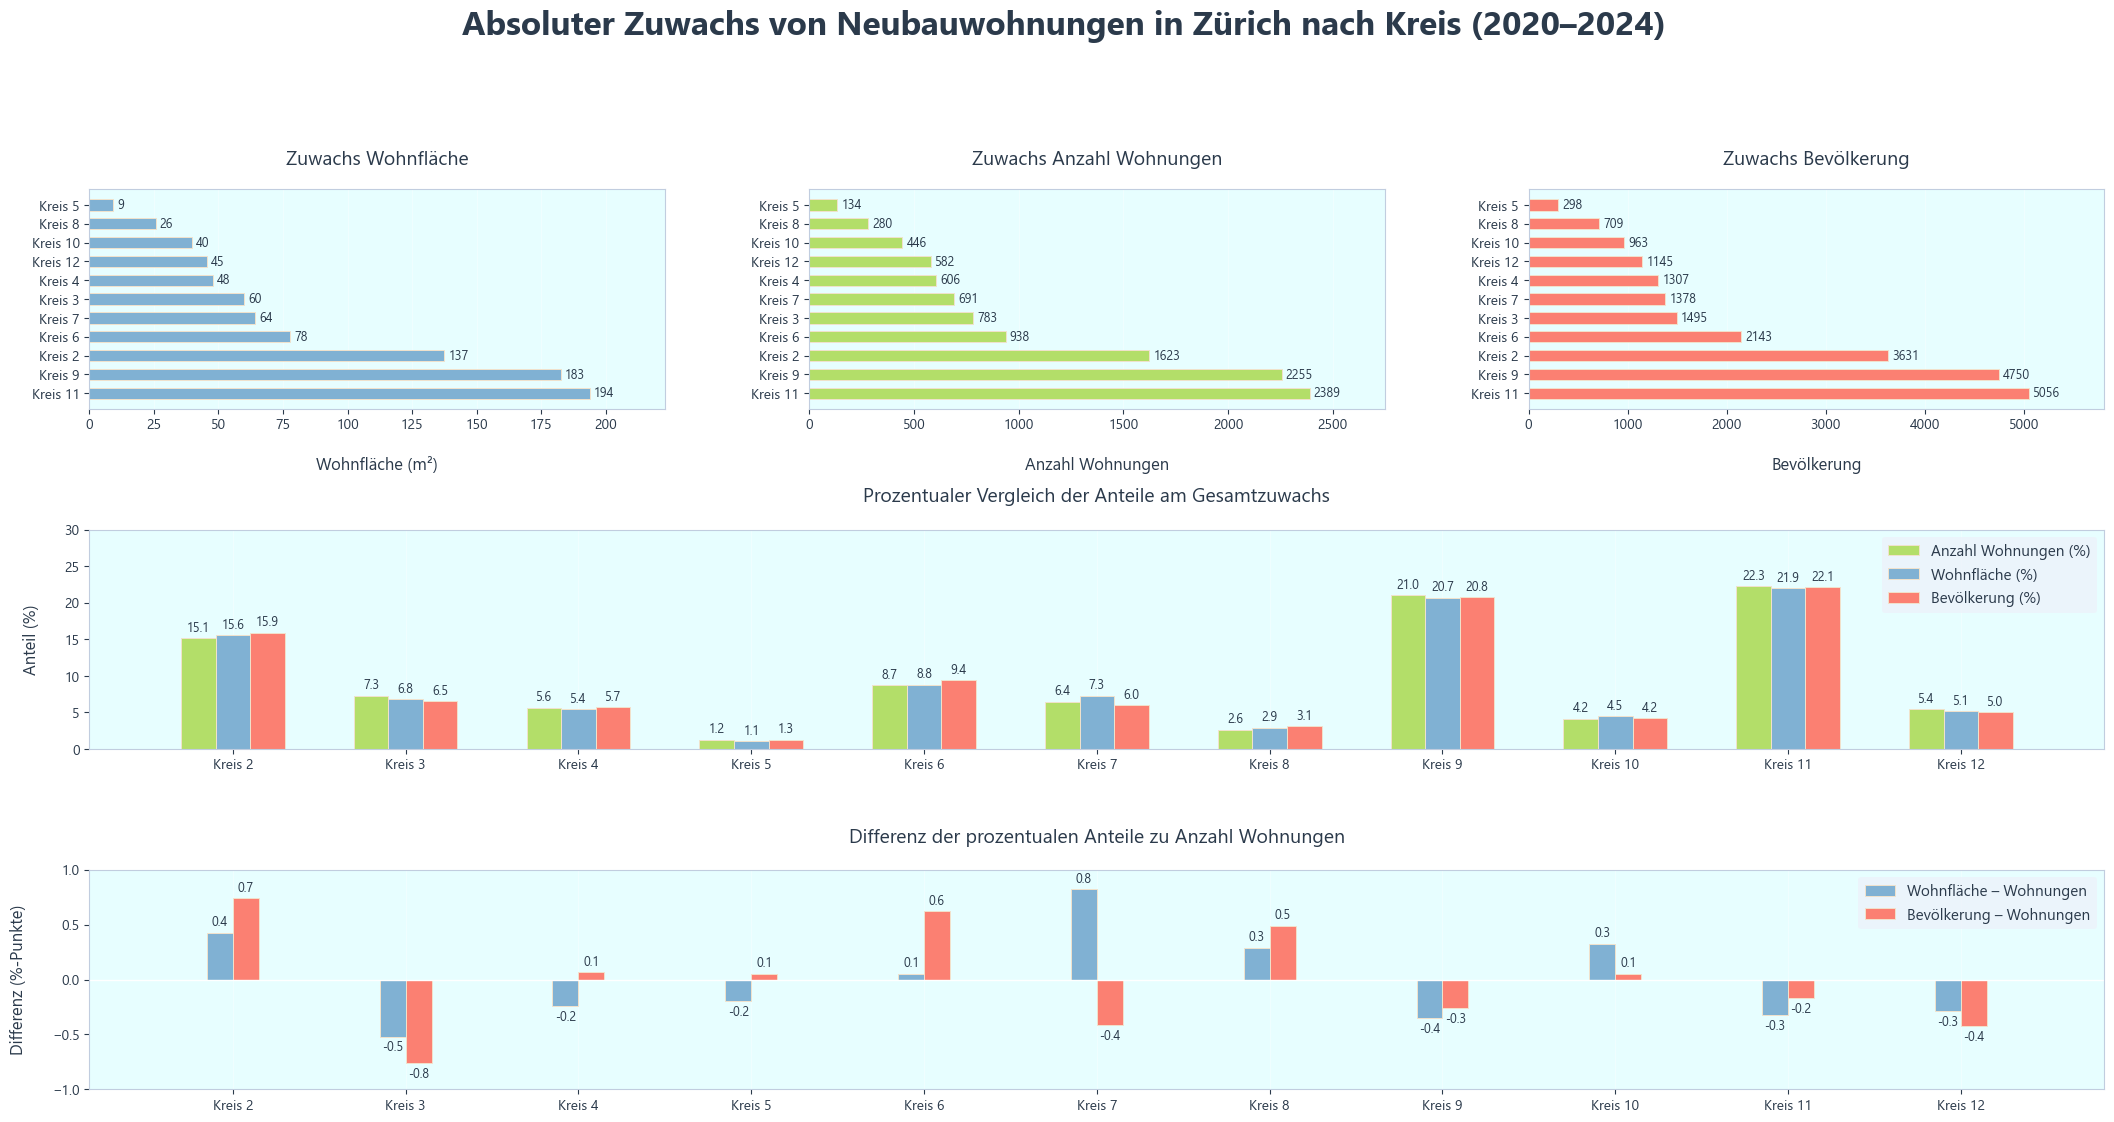

In [779]:
from matplotlib import pyplot as plt
import numpy as np
import matplotlib.gridspec as gridspec

# ============================================================
# Globaler Stil – Blue Harmony + professionelle Schrift
# ============================================================
plt.rcParams.update({
    "font.family": "Segoe UI",
    "font.size": 12,
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 11,
    "text.color": "#2B3A4B",
    "axes.labelcolor": "#2B3A4B",
    "axes.titlecolor": "#2B3A4B",
    "xtick.color": "#2B3A4B",
    "ytick.color": "#2B3A4B",
    "legend.edgecolor": "none",
})

figure_bg = "#ffffff"
axes_bg = "#e7feff"


color_living = "#80b1d3"
color_dwell  = "#b3de69"
color_pop    = "#fb8072"

edge_color   = "#f1e2cc"
grid_color   = "#ffffff"

# ============================================================
# Datenvorbereitung
# ============================================================
filtered = joined_df[joined_df["five_year_period"] == "2020–2024"]

df_3 = filtered[
    ["district_name", "living_area", "num_dwellings",
     "population_total", "five_year_period"]
].copy()

df_3["district_nr"] = df_3["district_name"].str.extract(r"Kreis (\d+)").astype(int)
df_3 = df_3.sort_values("district_nr")

# Basis-Achsenreihenfolge (für Prozent- und Differenzplots)
x = df_3["district_name"]

# Absolute Werte
living_abs    = df_3["living_area"] / 1000
dwellings_abs = df_3["num_dwellings"]
pop_abs       = df_3["population_total"]

# ============================================================
# Sortierte Daten für die oberen 3 Diagramme
# ============================================================

# Wohnfläche sortiert
df_living_sorted = df_3.sort_values("living_area", ascending=False)
x1 = df_living_sorted["district_name"]
living_abs_sorted = df_living_sorted["living_area"] / 1000

# Anzahl Wohnungen sortiert
df_dwell_sorted = df_3.sort_values("num_dwellings", ascending=False)
x2 = df_dwell_sorted["district_name"]
dwellings_abs_sorted = df_dwell_sorted["num_dwellings"]

# Bevölkerung sortiert
df_pop_sorted = df_3.sort_values("population_total", ascending=False)
x3 = df_pop_sorted["district_name"]
pop_abs_sorted = df_pop_sorted["population_total"]

# ============================================================
# Figure Setup
# ============================================================
fig1 = plt.figure(figsize=(26, 12))
fig1.patch.set_facecolor(figure_bg)

fig1.suptitle(
    "Absoluter Zuwachs von Neubauwohnungen in Zürich nach Kreis (2020–2024)",
    fontsize=24,
    fontweight="bold",
    y=1.01
)

# 3 Plot-Reihen
gs = gridspec.GridSpec(3, 3, figure=fig1)

ax_abs4 = fig1.add_subplot(gs[1, :])     # Prozent-Plot
ax_abs1 = fig1.add_subplot(gs[0, 0])     
ax_abs2 = fig1.add_subplot(gs[0, 1])
ax_abs3 = fig1.add_subplot(gs[0, 2])

ax_diff = fig1.add_subplot(gs[2, :], sharex=ax_abs4)

# ============================================================
# Helper: Achsenformat
# ============================================================
def format_axis(ax):
    ax.set_facecolor(axes_bg)
    ax.grid(axis="x", alpha=0.35, color=grid_color, linewidth=0.8)
    ax.set_axisbelow(True)
    for spine in ax.spines.values():
        spine.set_color("#C1CDDf")
        spine.set_linewidth(0.8)

# ============================================================
# Obere Plots: Horizontale Balken (links → rechts)
# ============================================================
bar_height = 0.6

# --- Wohnfläche ---
bars1 = ax_abs1.barh(
    x1, living_abs_sorted,
    bar_height,
    color=color_living, edgecolor=edge_color, linewidth=0.7
)
ax_abs1.set_title("Zuwachs Wohnfläche", pad=18)
ax_abs1.set_xlabel("Wohnfläche (m²)", labelpad=18)
ax_abs1.bar_label(bars1, padding=3, fmt="%.0f", fontsize=9)
format_axis(ax_abs1)
ax_abs1.set_xlim(0, living_abs_sorted.max() * 1.15)

# --- Anzahl Wohnungen ---
bars2 = ax_abs2.barh(
    x2, dwellings_abs_sorted,
    bar_height,
    color=color_dwell, edgecolor=edge_color, linewidth=0.7
)
ax_abs2.set_title("Zuwachs Anzahl Wohnungen", pad=18)
ax_abs2.set_xlabel("Anzahl Wohnungen", labelpad=18)
ax_abs2.bar_label(bars2, padding=3, fmt="%.0f", fontsize=9)
format_axis(ax_abs2)
ax_abs2.set_xlim(0, dwellings_abs_sorted.max() * 1.15)

# --- Bevölkerung ---
bars3 = ax_abs3.barh(
    x3, pop_abs_sorted,
    bar_height,
    color=color_pop, edgecolor=edge_color, linewidth=0.7
)
ax_abs3.set_title("Zuwachs Bevölkerung", pad=18)
ax_abs3.set_xlabel("Bevölkerung", labelpad=18)
ax_abs3.bar_label(bars3, padding=3, fmt="%.0f", fontsize=9)
format_axis(ax_abs3)
ax_abs3.set_xlim(0, pop_abs_sorted.max() * 1.15)

# ============================================================
# Prozentwerte – Reihenfolge: Wohnungen – Wohnfläche – Bevölkerung
# ============================================================
y_living_pct = living_abs    / living_abs.sum()    * 100
y_dwell_pct  = dwellings_abs / dwellings_abs.sum() * 100
y_pop_pct    = pop_abs       / pop_abs.sum()       * 100

x_pos = np.arange(len(x))
bar_width_bottom = 0.2

bars_y2 = ax_abs4.bar(
    x_pos - bar_width_bottom,
    y_dwell_pct,
    bar_width_bottom,
    color=color_dwell,
    edgecolor=edge_color,
    linewidth=0.7,
    label="Anzahl Wohnungen (%)",
)

bars_y1 = ax_abs4.bar(
    x_pos,
    y_living_pct,
    bar_width_bottom,
    color=color_living,
    edgecolor=edge_color,
    linewidth=0.7,
    label="Wohnfläche (%)",
)

bars_y3 = ax_abs4.bar(
    x_pos + bar_width_bottom,
    y_pop_pct,
    bar_width_bottom,
    color=color_pop,
    edgecolor=edge_color,
    linewidth=0.7,
    label="Bevölkerung (%)",
)

ax_abs4.set_title("Prozentualer Vergleich der Anteile am Gesamtzuwachs", pad=20)
ax_abs4.set_ylabel("Anteil (%)", labelpad=18)
ax_abs4.set_xticks(x_pos)
ax_abs4.set_xticklabels(x, ha="center")

legend = ax_abs4.legend(loc="upper right", frameon=True)
legend.get_frame().set_facecolor("#EDF2FA")

ax_abs4.bar_label(bars_y2, padding=3, fmt="%.1f", fontsize=9)
ax_abs4.bar_label(bars_y1, padding=3, fmt="%.1f", fontsize=9)
ax_abs4.bar_label(bars_y3, padding=3, fmt="%.1f", fontsize=9)

format_axis(ax_abs4)
ax_abs4.set_ylim(0, 30)

# ============================================================
# Differenzen – Wohnfläche – Bevölkerung relativ zu Wohnungen
# ============================================================
diff_living = y_living_pct - y_dwell_pct
diff_pop    = y_pop_pct    - y_dwell_pct

bar_width_diff = 0.15

bars_diff_living = ax_diff.bar(
    x_pos - bar_width_diff / 2,
    diff_living,
    bar_width_diff,
    color=color_living,
    edgecolor=edge_color,
    linewidth=0.7,
    label="Wohnfläche – Wohnungen",
)

bars_diff_pop = ax_diff.bar(
    x_pos + bar_width_diff / 2,
    diff_pop,
    bar_width_diff,
    color=color_pop,
    edgecolor=edge_color,
    linewidth=0.7,
    label="Bevölkerung – Wohnungen",
)

ax_diff.set_title("Differenz der prozentualen Anteile zu Anzahl Wohnungen", pad=20)
ax_diff.set_ylabel("Differenz (%-Punkte)", labelpad=18)

ax_diff.set_xticks(x_pos)
ax_diff.set_xticklabels(x, ha="center")
ax_diff.set_ylim(-1, 1)
ax_diff.axhline(0, color=grid_color, linewidth=1)

ax_diff.bar_label(bars_diff_living, padding=3, fmt="%.1f", fontsize=9)
ax_diff.bar_label(bars_diff_pop,    padding=3, fmt="%.1f", fontsize=9)

format_axis(ax_diff)

legend_diff = ax_diff.legend(loc="upper right", frameon=True)
legend_diff.get_frame().set_facecolor("#EDF2FA")

# ============================================================
# Layout
# ============================================================
plt.subplots_adjust(hspace=0.55, wspace=0.25, top=0.86)
plt.show()
